# Twitter Sentiment Investing Strategy
This notebook demonstrates how to implement an investing strategy based on Twitter sentiment data.

## Step 1: Load and Process Sentiment Data
We start by loading the sentiment data from a CSV file and processing it to compute the engagement ratio and filter the data.

In [1]:
pip install yfinance pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

# Load sentiment data
sentiment_data_path = "sentiment_data.csv"
sentiment_df = pd.read_csv(sentiment_data_path)

# Process sentiment data
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (sentiment_df['twitterComments'] > 10)]

## Step 2: Aggregate and Rank Data
We aggregate the data by month and rank the symbols based on their engagement ratio.

In [3]:
# Aggregate and rank data
aggregated_df = (sentiment_df.reset_index('symbol')
                 .groupby([pd.Grouper(freq='ME'), 'symbol'])
                 [['engagement_ratio']].mean())
aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

# Filter top symbols
filtered_df = aggregated_df[aggregated_df['rank'] < 6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

# Generate fixed dates dictionary
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {d.strftime('%Y-%m-%d'): filtered_df.xs(d, level=0).index.tolist() for d in dates}

## Step 3: Fetch Stock Prices
We fetch the stock prices for the symbols in the sentiment data using the `yfinance` library.

In [4]:
import yfinance as yf

# Fetch stock prices
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers=stocks_list, start='2021-01-01', end='2023-03-01')

# Debug: Verify prices_df structure
print("prices_df head:")
print(prices_df.head())

/Users/pratyushupadhyay/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


prices_df head:
Price        Adj Close                                                        \
Ticker               A    AAL         AAP        AAPL       ABBV         ABT   
Date                                                                           
2021-01-04  115.980721  15.13  144.788620  126.830101  90.489510  102.054939   
2021-01-05  116.928978  15.43  144.632172  128.398178  91.425217  103.317635   
2021-01-06  120.135490  15.52  152.987823  124.076088  90.635445  103.102516   
2021-01-07  123.332199  15.38  154.294540  128.309967  91.605492  104.103340   
2021-01-08  124.211998  15.13  156.493866  129.417435  92.086227  104.393280   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  71.591949  20.939249  148.095840  92.300003  ...  5732800   
2021-01-05  71.495361  21.642029  158.089844  92.76

## Step 4: Extract Adjusted Close Prices
We extract the adjusted close prices from the fetched stock prices data.

In [5]:
# Ensure 'Adj Close' exists and is structured properly
if 'Adj Close' not in prices_df.columns.levels[0]:
    raise ValueError("'Adj Close' not found in prices_df")

# Debug: Verify prices_df columns
print("prices_df columns:")
print(prices_df.columns)

# Extract 'Adj Close' prices
prices_adj_close = prices_df['Adj Close']

# Debug: Verify prices_adj_close
print("prices_adj_close head:")
print(prices_adj_close.head())

prices_df columns:
MultiIndex([('Adj Close',    'A'),
            ('Adj Close',  'AAL'),
            ('Adj Close',  'AAP'),
            ('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close',  'ABT'),
            ('Adj Close',  'AEP'),
            ('Adj Close',  'AES'),
            ('Adj Close',  'ALB'),
            ('Adj Close',  'AMD'),
            ...
            (   'Volume',  'RCL'),
            (   'Volume', 'REGN'),
            (   'Volume',  'SLB'),
            (   'Volume',  'STZ'),
            (   'Volume',    'T'),
            (   'Volume',  'TMO'),
            (   'Volume', 'TSLA'),
            (   'Volume',  'TSN'),
            (   'Volume',    'V'),
            (   'Volume',  'XOM')],
           names=['Price', 'Ticker'], length=510)
prices_adj_close head:
Ticker               A    AAL         AAP        AAPL       ABBV         ABT  \
Date                                                                           
2021-01-04  115.980721  15.13  

## Step 5: Handle NaN Values and Calculate Log Returns
We handle any NaN values in the adjusted close prices and calculate the log returns.

In [6]:
# Check for any NaN values and data types
print("prices_adj_close NaNs:")
print(prices_adj_close.isna().sum())

print("prices_adj_close data types:")
print(prices_adj_close.dtypes)

# Debug: Print the shape and index of prices_adj_close
print("prices_adj_close shape:", prices_adj_close.shape)
print("prices_adj_close index:", prices_adj_close.index)

# Ensure index is sorted
prices_adj_close.sort_index(inplace=True)

# Debug: Verify data after shifting
shifted_prices = prices_adj_close.shift(1)
print("shifted_prices head:")
print(shifted_prices.head())

# Calculate log returns without dropping NaNs
raw_log_returns = np.log(prices_adj_close / shifted_prices)
print("raw_log_returns head:")
print(raw_log_returns.head())

# Handle NaNs by filling them with zero
log_returns = raw_log_returns.fillna(0)
print("log_returns head after filling NaNs:")
print(log_returns.head())

# Print the index of log_returns to check available dates
print("Available dates in log_returns:")
print(log_returns.index)

prices_adj_close NaNs:
Ticker
A       0
AAL     0
AAP     0
AAPL    0
ABBV    0
       ..
TMO     0
TSLA    0
TSN     0
V       0
XOM     0
Length: 85, dtype: int64
prices_adj_close data types:
Ticker
A       float64
AAL     float64
AAP     float64
AAPL    float64
ABBV    float64
         ...   
TMO     float64
TSLA    float64
TSN     float64
V       float64
XOM     float64
Length: 85, dtype: object
prices_adj_close shape: (542, 85)
prices_adj_close index: DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17',
               '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='Date', length=542, freq=None)
shifted_prices head:
Ticker               A    AAL         AAP        AAPL 

## Step 6: Create Portfolio DataFrame
We create a DataFrame for the portfolio returns by calculating the average log returns for the selected symbols in each date range.

In [7]:
# Initialize empty DataFrame for portfolio returns
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    temp_df = log_returns.loc[start_date:end_date, cols].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df, temp_df])

# Display the final portfolio DataFrame
print("Final Portfolio DataFrame:")
print(portfolio_df)

Final Portfolio DataFrame:
            portfolio_return
Date                        
2021-12-01         -0.016417
2021-12-02          0.024872
2021-12-03         -0.007711
2021-12-06          0.023926
2021-12-07          0.030547
...                      ...
2023-02-22         -0.007870
2023-02-23         -0.007323
2023-02-24         -0.009463
2023-02-27         -0.001871
2023-02-28          0.001403

[312 rows x 1 columns]


In [8]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


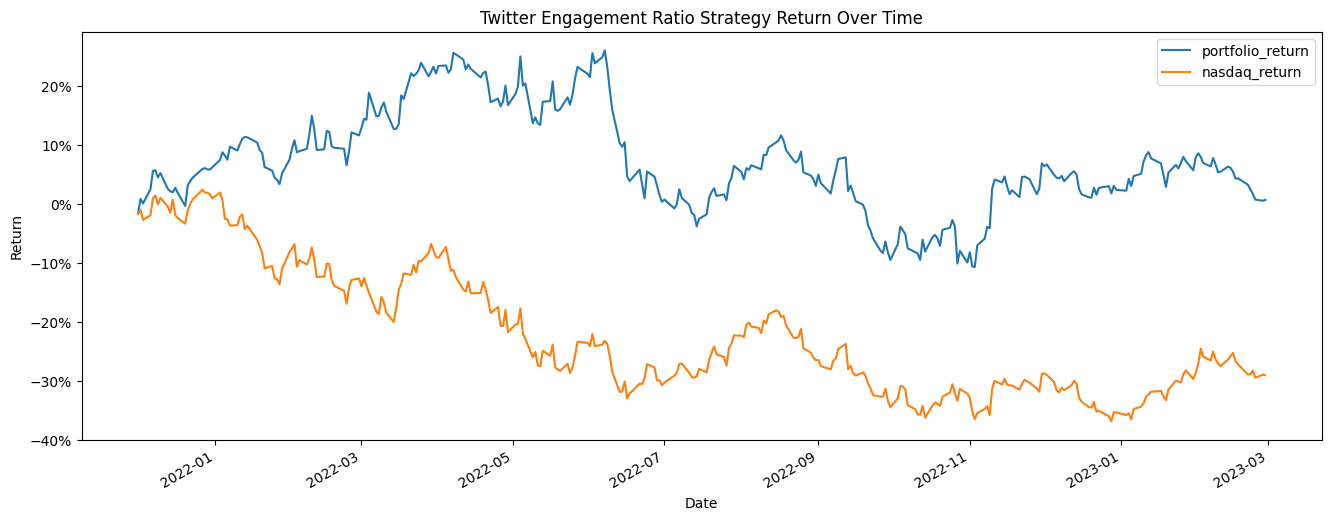

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

## Conclusion
We have successfully implemented a Twitter sentiment investing strategy, where we used Twitter sentiment data to select stocks and calculated portfolio returns based on the log returns of these selected stocks.